In [37]:
import pyspark
from pyspark.sql import SparkSession
import seaborn as sns
import pandas as pd

spark = SparkSession.builder \
    .appName("MyApp") \
    .getOrCreate()

### Data Loading

In [38]:

df = spark.read.csv("./originalDataSets/ecommerce_customer_data_large.csv", header=True, inferSchema=True)
df.show()

+-----------+-------------------+----------------+-------------+--------+---------------------+--------------+------------+-------+--------------+---+------+-----+
|Customer ID|      Purchase Date|Product Category|Product Price|Quantity|Total Purchase Amount|Payment Method|Customer Age|Returns| Customer Name|Age|Gender|Churn|
+-----------+-------------------+----------------+-------------+--------+---------------------+--------------+------------+-------+--------------+---+------+-----+
|      44605|2023-05-03 21:30:02|            Home|          177|       1|                 2427|        PayPal|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|2021-05-16 13:57:44|     Electronics|          174|       3|                 2448|        PayPal|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|2020-07-13 06:16:57|           Books|          413|       1|                 2345|   Credit Card|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|202

### Data Cleaning
#### Calculating NULL Values and Replacing it

In [39]:
null_counts = df.select([pyspark.sql.functions.count(pyspark.sql.functions.when(pyspark.sql.functions.col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+-----------+-------------+----------------+-------------+--------+---------------------+--------------+------------+-------+-------------+---+------+-----+
|Customer ID|Purchase Date|Product Category|Product Price|Quantity|Total Purchase Amount|Payment Method|Customer Age|Returns|Customer Name|Age|Gender|Churn|
+-----------+-------------+----------------+-------------+--------+---------------------+--------------+------------+-------+-------------+---+------+-----+
|          0|            0|               0|            0|       0|                    0|             0|           0|  47382|            0|  0|     0|    0|
+-----------+-------------+----------------+-------------+--------+---------------------+--------------+------------+-------+-------------+---+------+-----+



In [40]:
df = df.fillna({'Returns': 0})
df.show()

null_counts = df.select([pyspark.sql.functions.count(pyspark.sql.functions.when(pyspark.sql.functions.col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+-----------+-------------------+----------------+-------------+--------+---------------------+--------------+------------+-------+--------------+---+------+-----+
|Customer ID|      Purchase Date|Product Category|Product Price|Quantity|Total Purchase Amount|Payment Method|Customer Age|Returns| Customer Name|Age|Gender|Churn|
+-----------+-------------------+----------------+-------------+--------+---------------------+--------------+------------+-------+--------------+---+------+-----+
|      44605|2023-05-03 21:30:02|            Home|          177|       1|                 2427|        PayPal|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|2021-05-16 13:57:44|     Electronics|          174|       3|                 2448|        PayPal|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|2020-07-13 06:16:57|           Books|          413|       1|                 2345|   Credit Card|          31|    1.0|   John Rivera| 31|Female|    0|
|      44605|202

### Return Rates
#### Analyze returns and their correlation with different factors

In [41]:
# Add these imports at the top
import matplotlib.pyplot as plt
from pyspark.sql.functions import (
    sum, count, when, month, hour,
    dayofweek, col
)

In [45]:
# Create Price Bracket column
df = df.withColumn("Price Bracket",
    when(df["Product Price"] <= 50, "0-50")
    .when((df["Product Price"] > 50) & (df["Product Price"] <= 100), "51-100")
    .when((df["Product Price"] > 100) & (df["Product Price"] <= 200), "101-200")
    .when((df["Product Price"] > 200) & (df["Product Price"] <= 500), "201-500")
    .otherwise("500+"))

df = df.withColumn("Age Bracket",
    when(df["Age"] <= 25, "18-25")
    .when((df["Age"] > 25) & (df["Age"] <= 35), "26-35")
    .when((df["Age"] > 35) & (df["Age"] <= 45), "36-45")
    .when((df["Age"] > 45) & (df["Age"] <= 55), "46-55")
    .otherwise("55+"))

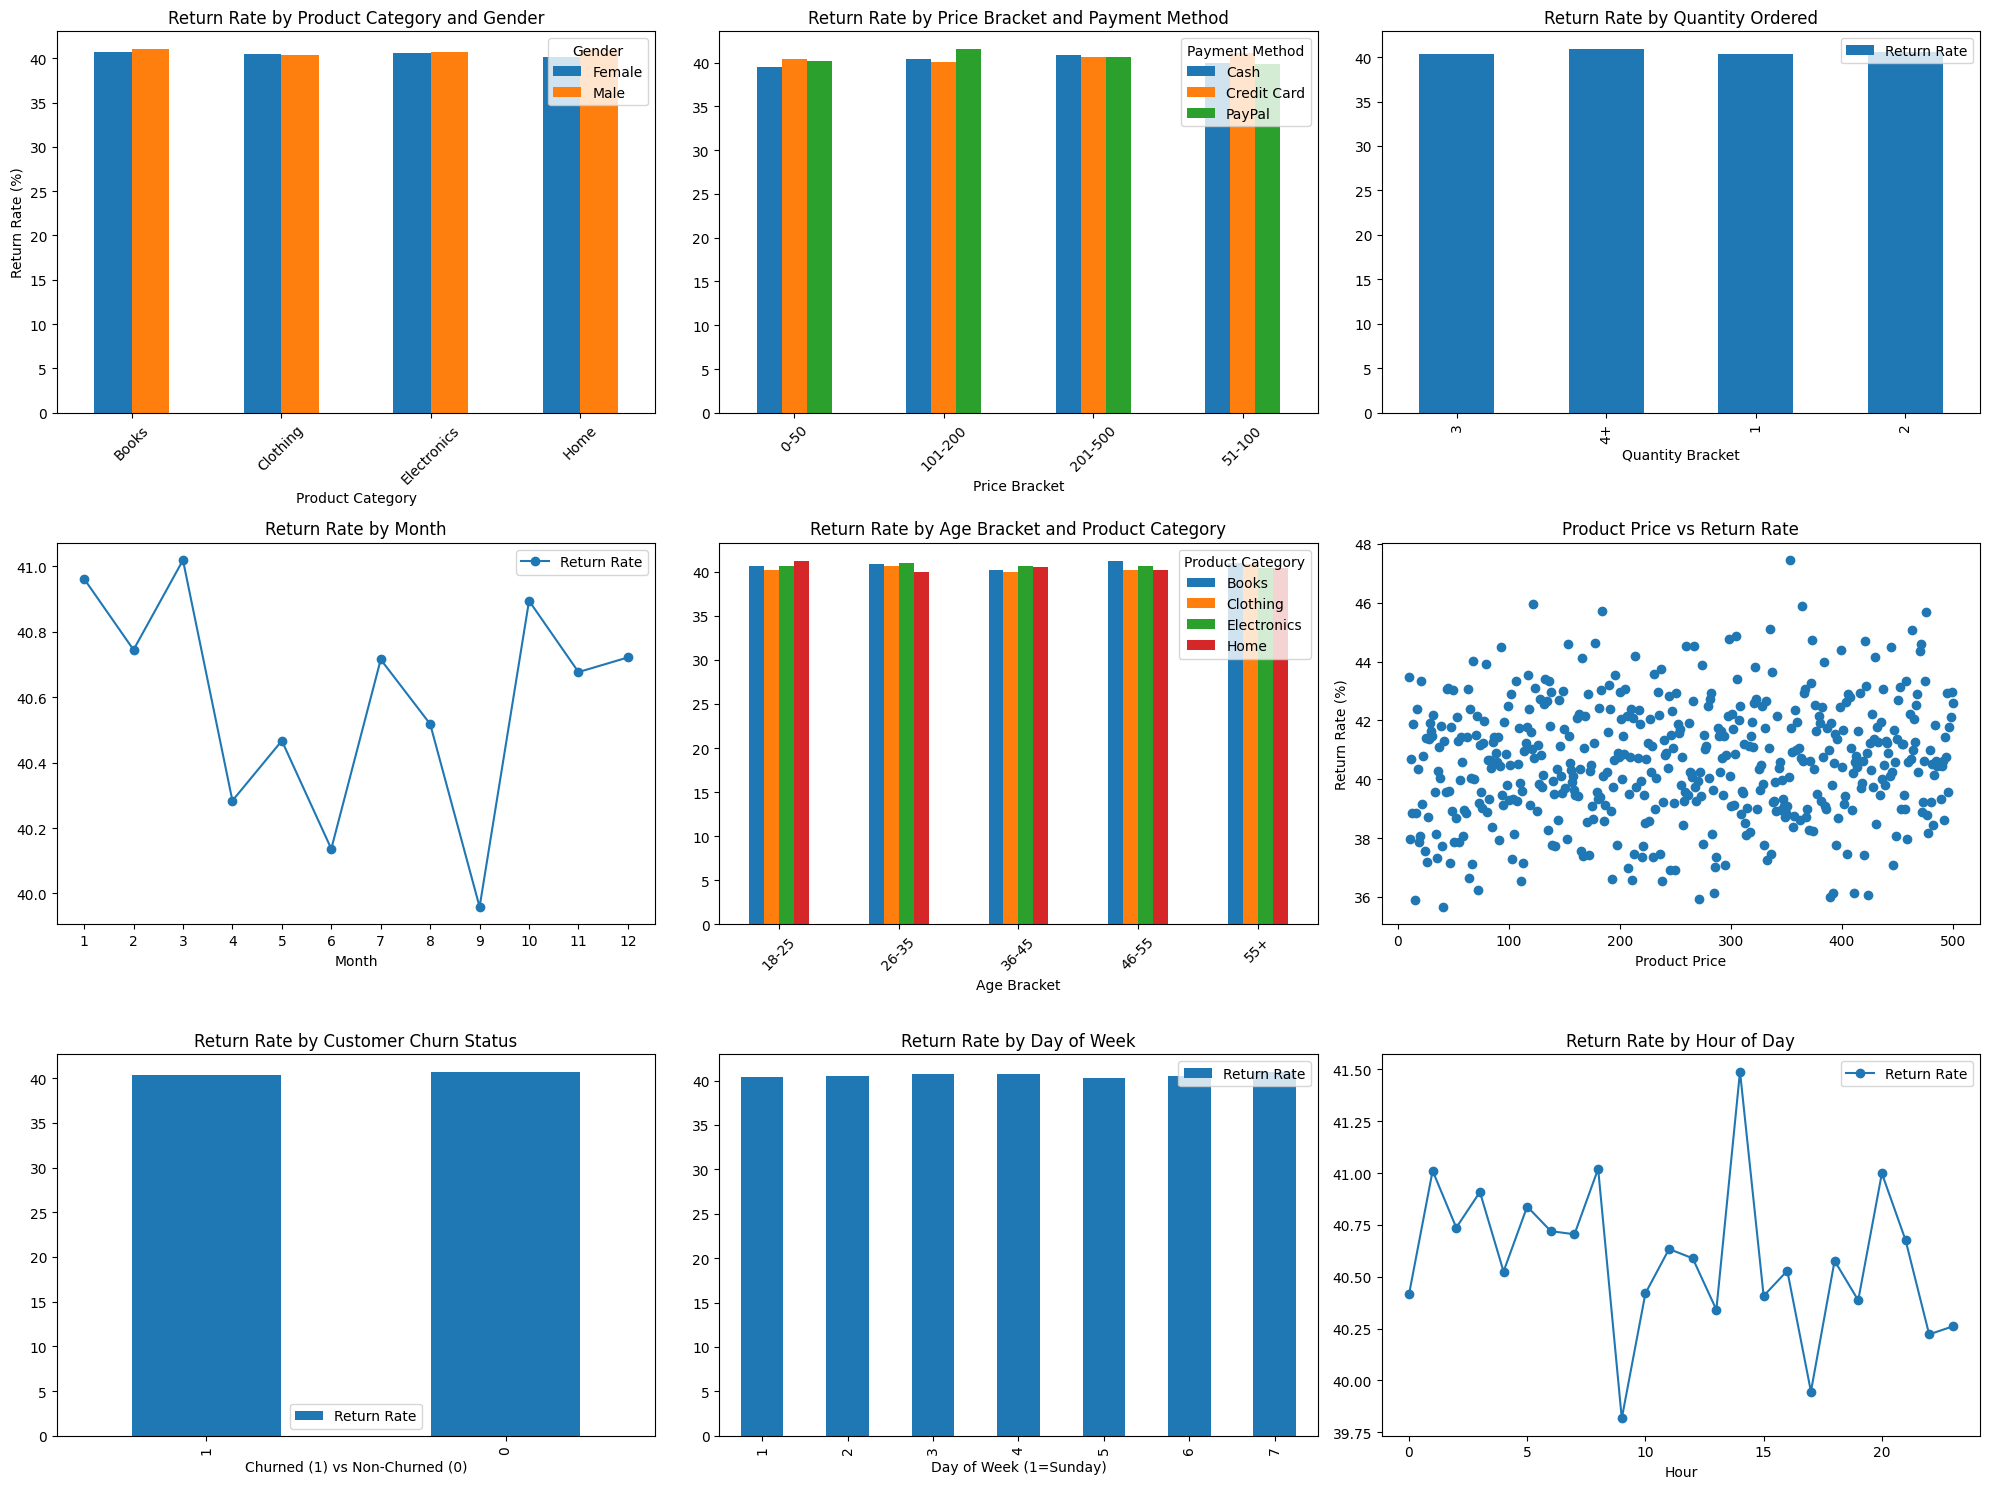


Correlation between Returns and Other Numeric Variables:
Age                     -0.000278
Product Price            0.004236
Quantity                 0.002966
Total Purchase Amount    0.001087
Returns                  1.000000
Name: Returns, dtype: float64

Chi-square test p-values for categorical variables:
Gender: 0.1445759931447082
Payment Method: 0.8411148401843501
Product Category: 0.5133121612520384
Age Bracket: 0.7992433832344827
Price Bracket: 0.2516637991318619


In [46]:
# Create multiple subplots
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
ax7 = fig.add_subplot(gs[2, 0])
ax8 = fig.add_subplot(gs[2, 1])
ax9 = fig.add_subplot(gs[2, 2])

# 1. Return Rate by Product Category and Gender
category_gender_returns = df.groupBy("Product Category", "Gender").agg(
    sum("Returns").alias("Total Returns"),
    count("*").alias("Total Orders"),
    (sum("Returns") / count("*") * 100).alias("Return Rate")
).toPandas()

category_gender_pivot = category_gender_returns.pivot(
    index='Product Category', columns='Gender', values='Return Rate')
category_gender_pivot.plot(kind='bar', ax=ax1)
ax1.set_title("Return Rate by Product Category and Gender")
ax1.set_xlabel("Product Category")
ax1.set_ylabel("Return Rate (%)")
ax1.tick_params(axis='x', rotation=45)

# 2. Return Rate by Price Bracket and Payment Method
price_payment_returns = df.groupBy("Price Bracket", "Payment Method").agg(
    (sum("Returns") / count("*") * 100).alias("Return Rate")
).toPandas()
price_payment_pivot = price_payment_returns.pivot(
    index='Price Bracket', columns='Payment Method', values='Return Rate')
price_payment_pivot.plot(kind='bar', ax=ax2)
ax2.set_title("Return Rate by Price Bracket and Payment Method")
ax2.tick_params(axis='x', rotation=45)

# 3. Return Rate by Quantity Ordered
df = df.withColumn("Quantity Bracket",
    when(df["Quantity"] == 1, "1")
    .when(df["Quantity"] == 2, "2")
    .when(df["Quantity"] == 3, "3")
    .otherwise("4+"))

quantity_returns = df.groupBy("Quantity Bracket").agg(
    (sum("Returns") / count("*") * 100).alias("Return Rate")
).toPandas()
quantity_returns.plot(kind='bar', x="Quantity Bracket", y="Return Rate", ax=ax3)
ax3.set_title("Return Rate by Quantity Ordered")

# 4. Return Rate by Month
df = df.withColumn("Month", month("Purchase Date"))
monthly_returns = df.groupBy("Month").agg(
    (sum("Returns") / count("*") * 100).alias("Return Rate")
).orderBy("Month").toPandas()
monthly_returns.plot(kind='line', x="Month", y="Return Rate", marker='o', ax=ax4)
ax4.set_title("Return Rate by Month")
ax4.set_xlabel("Month")
ax4.set_xticks(range(1, 13))

# 5. Return Rate by Age Bracket and Product Category
age_category_returns = df.groupBy("Age Bracket", "Product Category").agg(
    (sum("Returns") / count("*") * 100).alias("Return Rate")
).toPandas()
age_category_pivot = age_category_returns.pivot(
    index='Age Bracket', columns='Product Category', values='Return Rate')
age_category_pivot.plot(kind='bar', ax=ax5)
ax5.set_title("Return Rate by Age Bracket and Product Category")
ax5.tick_params(axis='x', rotation=45)

# 6. Average Product Price vs Return Rate
price_returns = df.groupBy("Product Price").agg(
    (sum("Returns") / count("*") * 100).alias("Return Rate")
).toPandas()
ax6.scatter(price_returns["Product Price"], price_returns["Return Rate"])
ax6.set_title("Product Price vs Return Rate")
ax6.set_xlabel("Product Price")
ax6.set_ylabel("Return Rate (%)")

# 7. Return Rate for Churned vs Non-Churned Customers
churn_returns = df.groupBy("Churn").agg(
    (sum("Returns") / count("*") * 100).alias("Return Rate")
).toPandas()
churn_returns.plot(kind='bar', x="Churn", y="Return Rate", ax=ax7)
ax7.set_title("Return Rate by Customer Churn Status")
ax7.set_xlabel("Churned (1) vs Non-Churned (0)")

# 8. Return Rate by Day of Week
df = df.withColumn("DayOfWeek", dayofweek("Purchase Date"))
dow_returns = df.groupBy("DayOfWeek").agg(
    (sum("Returns") / count("*") * 100).alias("Return Rate")
).orderBy("DayOfWeek").toPandas()
dow_returns.plot(kind='bar', x="DayOfWeek", y="Return Rate", ax=ax8)
ax8.set_title("Return Rate by Day of Week")
ax8.set_xlabel("Day of Week (1=Sunday)")

# 9. Return Rate by Hour of Day
df = df.withColumn("Hour", hour("Purchase Date"))
hour_returns = df.groupBy("Hour").agg(
    (sum("Returns") / count("*") * 100).alias("Return Rate")
).orderBy("Hour").toPandas()
hour_returns.plot(kind='line', x="Hour", y="Return Rate", marker='o', ax=ax9)
ax9.set_title("Return Rate by Hour of Day")
ax9.set_xlabel("Hour")

plt.tight_layout()
plt.show()

# Print statistical summaries
print("\nCorrelation between Returns and Other Numeric Variables:")
numeric_cols = ["Age", "Product Price", "Quantity", "Total Purchase Amount", "Returns"]
correlation_matrix = df.select(numeric_cols).toPandas().corr()["Returns"]
print(correlation_matrix)

# Chi-square test for categorical variables
from pyspark.sql.functions import col
from scipy.stats import chi2_contingency

def chi_square_test(df, categorical_col):
    contingency_table = df.crosstab(categorical_col, "Returns").toPandas()
    chi2, p_value, dof, expected = chi2_contingency(contingency_table.iloc[:, 1:])
    return categorical_col, p_value

categorical_cols = ["Gender", "Payment Method", "Product Category", "Age Bracket", "Price Bracket"]
print("\nChi-square test p-values for categorical variables:")
for col in categorical_cols:
    col_name, p_value = chi_square_test(df, col)
    print(f"{col_name}: {p_value}")

# Statistical Analysis of Returns

## Correlation Analysis
Correlation Coefficients (range from -1 to +1):
- Values close to 0 indicate no linear relationship
- Values close to 1 indicate strong positive correlation
- Values close to -1 indicate strong negative correlation

### Results:
1. **Age**: -0.000278
   - Extremely weak negative correlation
   - Practically no relationship between age and returns

2. **Product Price**: 0.004236
   - Extremely weak positive correlation
   - Almost no relationship between price and returns

3. **Quantity**: 0.002966
   - Extremely weak positive correlation
   - Almost no relationship between order quantity and returns

4. **Total Purchase Amount**: 0.001087
   - Extremely weak positive correlation
   - Almost no relationship between purchase amount and returns

## Chi-square Test Analysis
P-values (significance level = 0.05):
- If p-value < 0.05: statistically significant relationship
- If p-value > 0.05: no statistically significant relationship

### Results:
1. **Gender**: p = 0.145
   - Not statistically significant
   - Gender doesn't significantly influence returns

2. **Payment Method**: p = 0.841
   - Not statistically significant
   - Payment method doesn't significantly influence returns

3. **Product Category**: p = 0.513
   - Not statistically significant
   - Product category doesn't significantly influence returns

4. **Age Bracket**: p = 0.633
   - Not statistically significant
   - Age bracket doesn't significantly influence returns

5. **Price Bracket**: p = 0.252
   - Not statistically significant
   - Price bracket doesn't significantly influence returns

## Key Insights
- None of the numeric variables show any meaningful correlation with returns
- None of the categorical variables show statistically significant relationships with returns

This suggests that returns might be:
- Random in nature
- Influenced by factors not captured in the dataset
- Related to these variables in non-linear ways not captured by these tests

## Recommendations
Consider collecting additional data points such as:
- Reason for return
- Product satisfaction ratings
- Product defect rates
- Delivery time/quality